# Firewall based on weighted-CBA(classification based on associations)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
from apyori import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from pyarc_mdf import CBA, TransactionDB
import time
import fim
import matplotlib.pyplot as plt
import warnings
from ipywidgets import IntProgress
from IPython.display import display
warnings.filterwarnings(action='ignore') 

contribution 
1. association rule generation algorithm(apropri, fp_growth 등) 알고리즘 정확도,속도 비교
2. m3 rule: classification algorithm modify : weighted on  "deny" data association rules CBA (weighted CBA)
3. cba(classification based on association rules) algorithm compare : m1/m3

# 1. parsing data

pre-processing by human based feuture select & labeling

In [11]:
def parse_file() :
    log_data = pd.read_csv('data/data.csv')
    log_data = log_data.reindex([
        'Source Port', 
        'Destination Port', 
        'Bytes Sent', 
        'Bytes Received',
        'pkts_sent',
        'pkts_received',
        'Action'], axis=1)
    #for feature in log_data:  log_data[feature] = feature +"@"+log_data[feature].astype(str)
    return log_data
    
log_data =parse_file()

# 2. data loader

In [12]:
class DataLoader() :
    """
    data loader from data
    """
    
    def __init__(self, log_data):
        self.log_data = log_data
        
    def random_shuffle(self) :
        self.log_data = self.log_data.sample(frac=1).reset_index(drop=True)
        
    def get_data(self, start_rate, data_rate) :
        """
        Parameters
        ----------
        start_rate : float
            if you want get [40%:55%] data, set 0.4 this parameter
            
        data_rate : float
            if you want get [40%:55%] data, set 0.55-0.4= 0.15 this parameter
        """
        start_index = int(len(self.log_data)*start_rate)
        data_index = int(len(self.log_data)*data_rate)
        return self.log_data.loc[start_index:start_index+data_index]
        
dataloader = DataLoader(log_data)
dataloader.random_shuffle()

In [13]:
dataloader.get_data(0.5, 0.00005)

,Source Port,Destination Port,Bytes Sent,Bytes Received,pkts_sent,pkts_received,Action
32766,55072,53,86,82,1,1,allow
32767,32554,34729,62,0,1,0,deny
32768,56627,445,70,0,1,0,drop
32769,42665,80,2046,5605,10,6,allow


# 3. classification by association rules

In [123]:
class Experiment() :
    def __init__(self, dataloader) :
        self.dataloader = dataloader
    
    def set_data(self, test_start_rate, test_data_rate) :
        data_train = self.dataloader.get_data(0, test_start_rate)
        data_test = self.dataloader.get_data(test_start_rate, test_data_rate)
        data_train = pd.concat([ data_train, self.dataloader.get_data(test_start_rate+test_data_rate, 1)])
        self.txns_train = TransactionDB.from_DataFrame(data_train)
        self.txns_test = TransactionDB.from_DataFrame(data_test)
        self.txns_deny_train =  TransactionDB.from_DataFrame(data_train[data_train["Action"] != "allow"])
    
    def run(self, min_support, min_confidence, classification_algorithm, association_algorithm , top_rules_args = 0) :
        """Function for running CBA for finding the best n(top_rules_args)
        rules from transaction list
        
        Parameters
        ----------
        min_support : float
            set min support. if it setting 0.15 : association rule can make over 15% frequency.
            
        min_confidence: float
            set min confidence.
            
        classification_algorithm : string
            it can be 'm1', 'm2'
            
        association_algorithm : string
            it can be 'apriori', 'arules', 'eclat', 'fpgrowth'
        
        top_rules_args : int
            maximum assosiation rule number, if there is no rules, the whole rule num can be lower than args
            
        Returns
        ----------
        accuracy of experiment
        during time for experiment
        """
        start_time = time.time()
        self.cba = CBA(support=min_support, 
                  confidence=min_confidence, 
                  classification_algorithm=classification_algorithm, 
                  association_algorithm=association_algorithm)
        if classification_algorithm == "m3" : 
            self.cba.fit(self.txns_deny_train, int(top_rules_args*0.5))
            deny_rules =self.cba.clf.rules
            self.cba.fit(self.txns_train, int(top_rules_args*0.5))
            self.cba.clf.add_rules(deny_rules)
        else : 
            self.cba.fit(self.txns_train, top_rules_args)
        accuracy = self.cba.rule_model_accuracy(self.txns_test) 
        end_time = time.time()
        return accuracy , end_time-start_time
    
    def get_rules(self) :
        return self.cba.clf.rules
        

experiment = Experiment(dataloader)
experiment.set_data(0, 0.2)  # if training data is 0%~20% index
#experiment.run(0.20, 0.5, "m1", "apriori", 200)  #min support = 0.20, min_confidence = 0.5, max_rume_num = 200

In [104]:
print(experiment.run(0.1, 0.3, "m1", "apriori", 200)) #min support = 0.10, min_confidence = 0.3, max_rume_num = 80
experiment.get_rules()

(0.9746700236514839, 4.3841893672943115)


[CAR {pkts_received=1,pkts_sent=1} => {Action=allow} sup: 0.23 conf: 1.00 len: 3, id: 121963,
 CAR {Destination Port=53,pkts_received=1} => {Action=allow} sup: 0.21 conf: 1.00 len: 3, id: 121947,
 CAR {pkts_received=1} => {Action=allow} sup: 0.25 conf: 1.00 len: 2, id: 121965,
 CAR {Destination Port=443} => {Action=allow} sup: 0.18 conf: 1.00 len: 2, id: 121863,
 CAR {Destination Port=53} => {Action=allow} sup: 0.24 conf: 1.00 len: 2, id: 121958,
 CAR {Destination Port=445} => {Action=drop} sup: 0.20 conf: 1.00 len: 2, id: 121887,
 CAR {pkts_sent=1,pkts_received=0} => {Action=deny} sup: 0.23 conf: 0.50 len: 3, id: 121933]

In [105]:
print(experiment.run(0.1, 0.3, "m3", "apriori", 200)) #min support = 0.10, min_confidence = 0.3, max_rume_num = 80
experiment.get_rules()

(0.9688715953307393, 4.2855446338653564)


[CAR {Bytes Sent=66,Destination Port=445} => {Action=drop} sup: 0.15 conf: 1.00 len: 3, id: 122032,
 CAR {Bytes Sent=62} => {Action=deny} sup: 0.20 conf: 1.00 len: 2, id: 121979,
 CAR {Bytes Sent=70,Destination Port=445} => {Action=drop} sup: 0.31 conf: 1.00 len: 3, id: 121991,
 CAR {Destination Port=443} => {Action=allow} sup: 0.18 conf: 1.00 len: 2, id: 122121,
 CAR {Destination Port=445} => {Action=drop} sup: 0.20 conf: 1.00 len: 2, id: 122133,
 CAR {pkts_sent=1,pkts_received=0} => {Action=deny} sup: 0.23 conf: 0.50 len: 3, id: 122167]

# 4. experiment

use cross validation -> 데이터를 5분할 후, 각 분할 하나를 test set, 나머지를 training set 으로 보고 실험을 총 5번하여 결과를 합산

In [115]:
cross_validation_epoch = 5
top_rule_max_num_list = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200] # 40,80,120,160,200
minimum_support = 0.01 
minimum_confidence = 0.2
classification_algorithm_list = ['m1', 'm3'] # 'm1', 'm2'
association_algorithm_list = ['apriori', 'arules', 'eclat', 'fpgrowth'] # 'apriori', 'arules', 'eclat', 'fpgrowth'
full_loop_num = cross_validation_epoch * len(top_rule_max_num_list) * len(classification_algorithm_list) * len(association_algorithm_list)
print(f"total_epoch: {full_loop_num}")

total_epoch: 760


In [124]:
result = dict()
for classification_algorithm in classification_algorithm_list :
    result[classification_algorithm] = dict()
    for association_algorithm in association_algorithm_list :
        result[classification_algorithm][association_algorithm] = dict()
        result[classification_algorithm][association_algorithm]["acc"] = [0]*len(top_rule_max_num_list)
        result[classification_algorithm][association_algorithm]["time"] = [0]*len(top_rule_max_num_list)

pb = IntProgress(min=0, max=full_loop_num) # instantiate the bar
display(pb) # display the bar

for five_cross_validation in [(x/cross_validation_epoch,1/cross_validation_epoch) for x in range(cross_validation_epoch) ] :
    experiment.set_data(*five_cross_validation)
    for classification_algorithm in classification_algorithm_list :
        for association_algorithm in association_algorithm_list :
            for i, rule_max_num in enumerate(top_rule_max_num_list) :
                acc, t = experiment.run(minimum_support, minimum_confidence, classification_algorithm, association_algorithm, rule_max_num)
                result[classification_algorithm][association_algorithm]["acc"][i] += acc/cross_validation_epoch
                result[classification_algorithm][association_algorithm]["time"][i] +=  t/cross_validation_epoch
                pb.value += 1
                
pb.close()

IntProgress(value=0, max=760)

# 5. visualize

In [125]:
acc_dict = dict()
time_dict = dict()

for meth in result :
    for algo in result[meth] :
        label=f"{meth}-{algo}"
        acc_dict[label] = dict()
        time_dict[label] = dict()
        for i, rume_num in enumerate(top_rule_max_num_list) :
            acc_dict[label][rume_num] = result[meth][algo]["acc"][i]
            time_dict[label][rume_num] = result[meth][algo]["time"][i]
            
acc_df = pd.DataFrame(acc_dict)
time_df = pd.DataFrame(time_dict)

def visualize(df1, t1,x1,y1, df2,t2,x2,y2) :
    fig, ax=plt.subplots(2)
    plt.tight_layout()
    df1.plot(ax=ax[0], figsize=(10,10))
    ax[0].set_title(t1, fontsize=20)
    ax[0].set_xlabel(x1, fontsize=13)
    ax[0].set_ylabel(y1, fontsize=13)

    df2.plot(ax=ax[1], figsize=(10,10))
    ax[1].set_title(t2, fontsize=20)
    ax[1].set_xlabel(x2, fontsize=13)
    ax[1].set_ylabel(y2, fontsize=13)

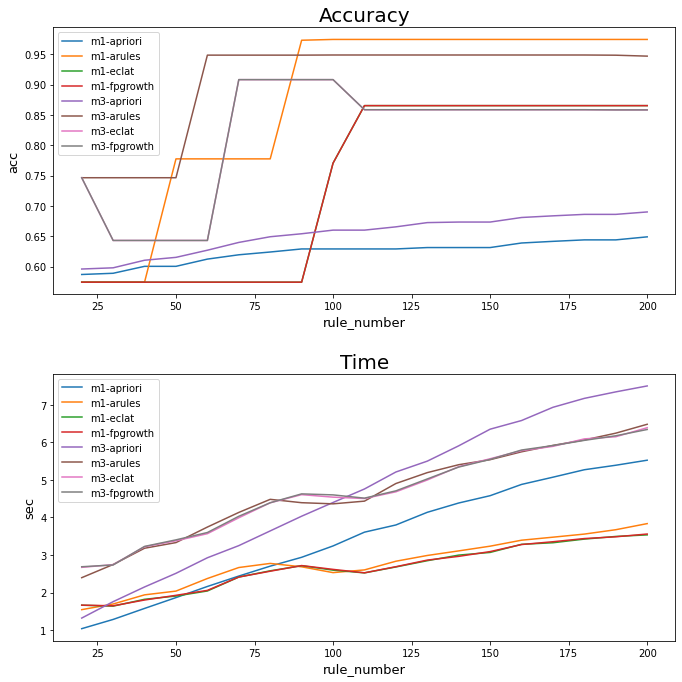

In [126]:
visualize(acc_df,'Accuracy',"rule_number","acc",time_df,'Time',"rule_number","sec")

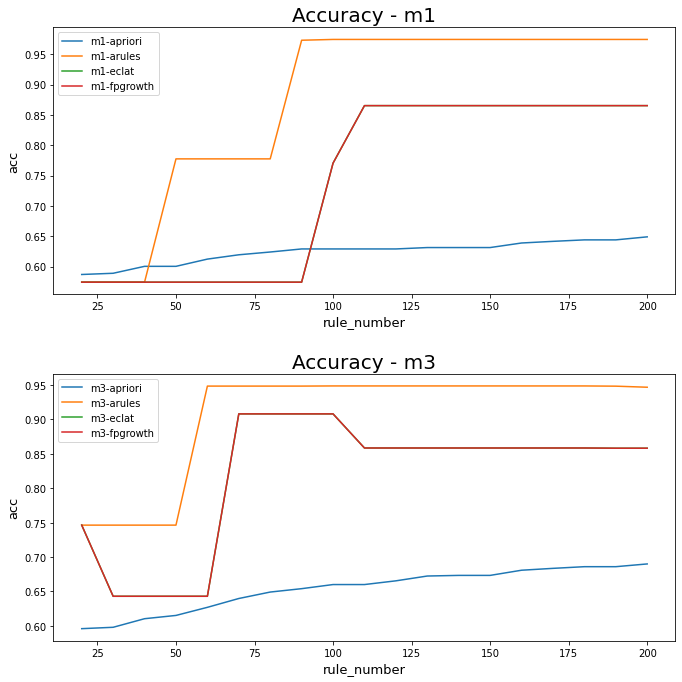

In [127]:
visualize(acc_df[[ x  for x in list(acc_df.columns) if 'm1' in x]],
          'Accuracy - m1',"rule_number","acc",
          acc_df[[ x  for x in list(acc_df.columns) if 'm3' in x]],
          'Accuracy - m3',"rule_number","acc")

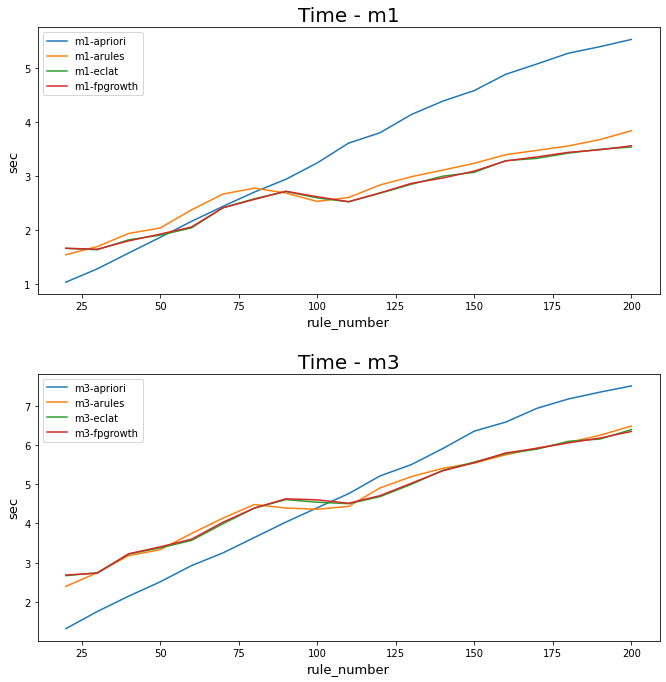

In [128]:
visualize(time_df[[ x  for x in list(time_df.columns) if 'm1' in x]],
          'Time - m1',"rule_number","sec",
          time_df[[ x  for x in list(time_df.columns) if 'm3' in x]],
          'Time - m3',"rule_number","sec")

# 6. Conclusion

규칙의 수가 적을수록, deny 데이터의 연관성을 기반으로 association rule 을 작성한것이, 전체 데이터의 연관성을 기반으로 작성한것보다 정확도가 높음
따라서 특정 데이터에 따라 본 논문에서 제시한 class-weighted 기반 CBA 가 의미있는 알고리즘이 될 수 있다.